# Which online marketing tools are used most?
While working on a project and deciding which tool to use for analytics, following customers, etc. I noticed the vast amounts of different tools some companies use on their website. I figured, why not find out which tools are used most. I'll start out saying that my approach is not perfect, but it works very well to get an overview. Bear with me as we move on to figure out the question to our answer. Let's start with our basic setup.

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import re
import csv
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

#variables
lxa_n = 20 #number of Alexa pages to scrape (25 sites per page)

Next up are some basic functions to get the job done. I'll give you a quick overview of my approach in gathering the data. The first question is what companies do we want in our data set? I've decided to go for the top 500 of dutch websites as index by Alexa. Now, I didn't really want to get the generic websites, but rather the specific 'Dutch' approach to online marketing. As a crude measure I decided to just use the sites with domain names ending in .nl.

Most of these site use javascripts to trigger their online marketing tools. However, some of these scripts are loaded asynchronously, so it's not enough to just make a request, we have to render the javascript as well. The best way in this case was using Selenium to automate that process.

In [13]:
def get_top_sites():
    top_links = []
    for i in range(lxa_n):
        lxa_url = "http://www.alexa.com/topsites/countries;%s/NL" % str(i)
        lxa = make_request(lxa_url).content
        soup = BeautifulSoup(lxa, "lxml")
        for link in soup.find_all('p', {'class' : 'desc-paragraph'}):
            if ".nl" in link.text:                          # only use dutch sites
                top_links.append(link.text)
    
    return top_links

def make_request(url):
    headers = {'User-Agent' : 'Mozilla/5.0 Chrome/51.0.2704.106 Safari/537.36)'}
    req = requests.get(url, headers=headers) 
    return req


def make_request_async(url):
    browser = webdriver.Firefox()
    browser.get(url)
    source = browser.page_source
    browser.quit()
    return source

def extract(html):
    soup = BeautifulSoup(html, "lxml")
    return [script.get('src') for script in soup.find_all('script')]

def extract_link(html):
    soup = BeautifulSoup(html, "lxml")
    for link in soup.find_all('p'):
        print link.text

def get_used_scripts(site_list):
    used_scripts = {}
    for site in site_list:
        url = "http://www.%s" % site
        site_scripts = extract(make_request_async(url))
        used_scripts[site.strip()] = site_scripts
    
    return used_scripts

def dict_to_csv(data, name):
    with open(name, 'w') as f:
        w_csv = csv.writer(f)
        for k,v in data.items():
            w_csv.writerow([k.strip(), ",".join([str(x) for x in v])])

In [3]:
#common tools
tools = ["google-analytics", "piwik", "optimizely", "r42", "hotjar", "visualwebsiteoptimizer", 
      "usabilla", "adobedtm", "scorecardresearch", "nr-data", "crazyegg", "chartbeat", "krxd", "kiss"]
frameworks = ["jquery", "angular", "bootstrap", "node", "underscore", "backbone"]

We use [Alexa's top 1 million](https://support.alexa.com/hc/en-us/articles/200449834-Does-Alexa-have-a-list-of-its-top-ranked-websites-) list of websites to get 7575 .nl websites.

In [249]:
alexa_1_million = pd.read_csv('top-1m.csv', names=["site"])
alexa_1m_nl = alexa_1_million[alexa_1_million['site'].str.contains("\.nl")]

In [11]:
#top_sites_used_scripts = get_used_scripts(alexa_1m_nl) 

,site,scripts
0,Rechtspraak.nl,/_layouts/15/init.js?rev=0%2BjgcYFw8Xoj0N42kzP...
1,Vergelijk.nl,"//connect.facebook.net/nl_NL/sdk.js,//www.goog..."
2,Neckermann.nl,https://bam.nr-data.net/1/db89e40b45?a=1283469...
3,Exactonline.nl,"http://www.google-analytics.com/ga.js,None"
4,Nu.nl,"None,None,None"


In [12]:
top_sites_used_tools = {}

for site in top_sites_used_scripts.head():
    tools_used = {}
    for tool in tools:
        for item in top_sites_used_scripts[site]:
            if item is not None:
                if tool in item:
                    tools_used[tool] = 1
    top_sites_used_tools[site] = tools_used            
    
top_sites_used_tools

NameError: name 'i' is not defined

In [251]:
top_sites_used_frameworks = {}

for site in top_sites_used_scripts:
    f_used = {}
    for f in frameworks:
        for item in top_sites_used_scripts[site]:
            if item is not None:
                if f in item:
                    f_used[f] = 1
    top_sites_used_frameworks[site] = f_used  

In [252]:
dict_to_csv(top_sites_used_scripts, 'top_sites_used_scripts.csv')

In [253]:
df_frameworks = pd.DataFrame(data=top_sites_used_frameworks).transpose().fillna(0)
df_frameworks.to_csv('online_marketing_frameworks.csv')

In [254]:
df_tools = pd.DataFrame(data=top_sites_used_tools).transpose().fillna(0)
df_tools.to_csv('online_marketing_tools.csv')

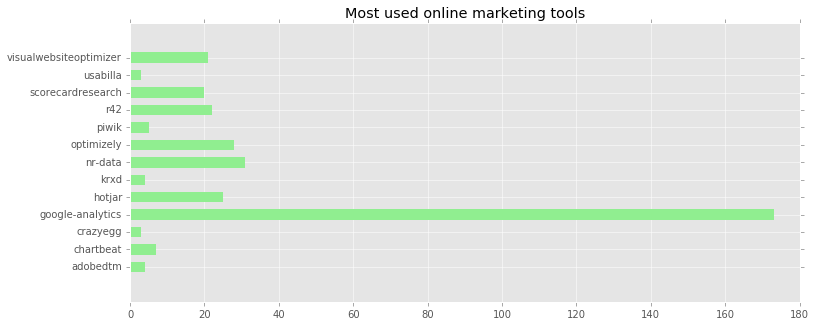

In [255]:
fig, ax = plt.subplots(1,1, figsize=[12,5])
ind = np.arange(len(df_tools.sum()))
width=0.6
ax.barh(ind, df_tools.sum(), width, align='center', color='lightgreen', edgecolor='None')
ax.set(yticklabels=df_tools.sum().index)
ax.set_yticks(ind)
ax.set_title('Most used online marketing tools')
plt.show()

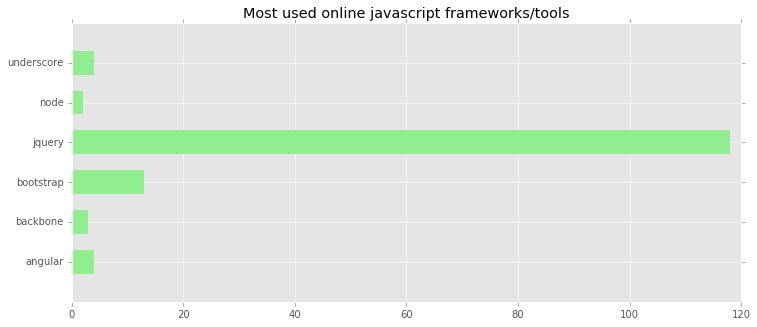

In [256]:
fig, ax = plt.subplots(1,1, figsize=[12,5])
ind = np.arange(len(df_frameworks.sum()))
width=0.6
ax.barh(ind, df_frameworks.sum(), width, align='center', color='lightgreen', edgecolor='None')
ax.set(yticklabels=df_frameworks.sum().index)
ax.set_yticks(ind)
ax.set_title('Most used online javascript frameworks/tools')
plt.show()
